## Step 1: Read data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm_notebook
from keras.optimizers import Adam, SGD

In [ ]:
train_img_path = "/content/drive/My Drive/jobe/dataset/train/*.jpg"
train_label_path = "/content/drive/My Drive/jobe/dataset/train/*.txt"
test_img_path = "/content/drive/My Drive/jobe/dataset/valid/*.jpg"
test_label_path = "/content/drive/My Drive/jobe/dataset/valid/*.txt"

In [ ]:
def read_data(image_path, label_path):  
  templates_files = glob.glob(image_path)
  templates = []
  labels = []
  for tn in tqdm_notebook(range(len(templates_files)), desc = 'load images'):
    t = templates_files[tn]
    img = cv2.imread(t)
    templates.append(img)
    labels.append(t.split('/')[-1].split('.')[0])
  labels, templates = zip(*sorted(zip(labels, templates)))
  print('# images : {}'.format(len(templates)))
  # read txt files. output format: [#box, #calss, x1, y1, x2, y2]
  labels_files = glob.glob(label_path)
  true_labes = []
  labels = []
  for tn in tqdm_notebook(range(len(labels_files)), desc = 'load labels'):
    file_path = labels_files[tn]
    x, y, w, h, label = [], [], [], [], []
    with open(file_path) as fp:
      for cnt, line in enumerate(fp):
        ww = int(float(line.split(' ')[2])) - int(float(line.split(' ')[0]))
        hh = int(float(line.split(' ')[3])) - int(float(line.split(' ')[1]))
        x.append(int(float(line.split(' ')[0])) + (ww/2))
        y.append(int(float(line.split(' ')[1])) + (hh/2))
        w.append(ww)
        h.append(hh)
        label.append(int(float(line.split(' ')[4])))
    box_per_image = np.asarray(list(zip(label, x, y, w, h)))
    true_labes.append(np.asarray(box_per_image))
    labels.append(file_path.split('/')[-1].split('.')[0])
  labels, true_labes = zip(*sorted(zip(labels, true_labes)))
  print('# labels : {}'.format(len(true_labes)))
  return templates, true_labes ## (cx, cy, w, h)

def plot_one_sample(sample, label, score = False, org_image = False):
  n_classes = 2
  classes = ['background', 'baseball', 'tennis']
  colors = ['red', 'blue']
  plt.figure(figsize=(20,12))
  plt.imshow(sample)
  current_axis = plt.gca()
  for box in label:
    if score == True:
      w = box[4]
      h = box[5]
      x = box[2] - (w/2)
      y = box[3] - (h/2)
    else:
      w = box[3]
      h = box[4]
      x = box[1] - (w/2)
      y = box[2] - (h/2)
    if org_image == True:
      new_size = 300
      hh = sample.shape[0] / new_size
      ww = sample.shape[1] / new_size
      w = w*ww
      h = h*hh
      x = x*ww
      y = y*hh
      
    color = colors[int(box[0]) - 1]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((x, y), w, h, color=color, fill=False, linewidth=2)) 
    if score == True: 
      current_axis.text(x, y, '{}'.format(round(box[1], 2)), size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

#### load training images along with corespanding labels

In [5]:
## load
train_image, train_label = read_data(train_img_path, train_label_path)


# images : 316



# labels : 316


## step 2: Augmentation

In [ ]:

def augment_data(img, label):
  aug_data = []
  aug_label = []
  for i in tqdm_notebook(range(len(img)), desc = 'Augmentating data'):
    aug_data.append(img[i])
    aug_label.append(label[i])
    if len(label[i]) > 0 :
      one = np.copy(img[i])
      one_label = np.copy(label[i])
      img_h, img_w, img_c = one.shape
      # 180 cv2.ROTATE_180
      new_label = []
      for box in one_label: # class, cx, cy, w, h
        box[1] = img_w - box[1]
        box[2] = img_h - box[2]
        new_label.append(box)
      img_rotate_180 = cv2.rotate(one, cv2.ROTATE_180)
      aug_data.append(img_rotate_180)
      aug_label.append(new_label)

      # 90 clockwize
      one = np.copy(img[i])
      one_label = np.copy(label[i])
      img_h, img_w, img_c = one.shape
      new_label = []
      for box in one_label:
        cx, cy, w, h = box[1], box[2], box[3], box[4]
        box[1] = img_h - cy
        box[2] = cx
        box[3] = h
        box[4] = w
        new_label.append(box)
      img_rotate_90_cl = cv2.rotate(one, cv2.ROTATE_90_CLOCKWISE)
      aug_data.append(img_rotate_90_cl)
      aug_label.append(new_label)

      # 90 COUNTERCLOCKWISE
      one = np.copy(img[i])
      one_label = np.copy(label[i])
      img_h, img_w, img_c = one.shape
      new_label = []
      for box in one_label:
        cx, cy, w, h = box[1], box[2], box[3], box[4]
        box[1] = cy
        box[2] = img_w - cx
        box[3] = h
        box[4] = w
        new_label.append(box)
      img_rotate_90_co = cv2.rotate(one, cv2.ROTATE_90_COUNTERCLOCKWISE)
      aug_data.append(img_rotate_90_co)
      aug_label.append(new_label)
  
  # np.save('/content/drive/My Drive/jobe/dataset/augmented/aug_data.npy', aug_data)
  # np.save('/content/drive/My Drive/jobe/dataset/augmented/aug_label.npy', aug_label)

  return aug_data, aug_label

In [7]:
aug_data, aug_label = augment_data(train_image, train_label)
# aug_data = np.load('/content/drive/My Drive/jobe/dataset/augmented/aug_data.npy', allow_pickle= True)
# aug_label = np.load('/content/drive/My Drive/jobe/dataset/augmented/aug_label.npy', allow_pickle= True)

In [8]:
len(aug_data)

868

## Step 3: design model

In [ ]:
from keras.layers import Input, Conv2D, Reshape, MaxPooling2D, Concatenate, Activation
from keras.models import Model

def ssd_model(input_shape = (300,300,3), n_class= 2, unc = False, add_weight = True):

  n_class += 1 # +1 forunc and bg
  if unc == True:
    n_class += 1

  # VGG16 : .../keras_applications/vgg16.py
  img_input = Input(shape=input_shape, name='input')
  # Block 1
  conv1_1 =  Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(img_input)
  conv1_2 =  Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(conv1_1)
  pool1 =  MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)
  # Block 2
  conv2_1 =  Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1)
  conv2_2 =  Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(conv2_1)
  pool2 =  MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)
  # Block 3
  conv3_1 =  Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2)
  conv3_2 =  Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(conv3_1)
  conv3_3 =  Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(conv3_2)
  pool3 =  MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)
  # Block 4
  conv4_1 =  Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(pool3)
  conv4_2 =  Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(conv4_1)
  conv4_3 =  Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(conv4_2)
  pool4 =  MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)
  # Block 5
  conv5_1 =  Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(pool4)
  conv5_2 =  Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(conv5_1)
  conv5_3 =  Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(conv5_2)
  pool5 =  MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool5')(conv5_3)

  ##
  FC6 = Conv2D(1024, (3, 3), activation='relu', padding='same', name='conv6')(conv5_3)
  FC7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name='conv7')(FC6)

  conv8_1 = Conv2D(256, (1, 1), activation='relu', padding='same', name='conv8_1')(FC7)
  conv8_2 = Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='same', name='conv8_2')(conv8_1)

  conv9_1 = Conv2D(128, (1, 1), activation='relu', padding='same', name='conv9_1')(conv8_2)
  conv9_2 = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same', name='conv9_2')(conv9_1)

  conv10_1 = Conv2D(128, (1, 1), activation='relu', padding='same', name='conv10_1')(conv9_2)
  conv10_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', name='conv10_2')(conv10_1)

  conv11_1 = Conv2D(128, (1, 1), activation='relu', padding='same', name='conv11_1')(conv10_2)
  conv11_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', name='conv11_2')(conv11_1)

  n_boxes = [4, 6, 6, 6, 4, 4]
  ##class
  conv4_3_class =  Conv2D(n_boxes[0]*n_class, (3, 3), activation='relu', padding='same', name='conv4_3_class')(conv4_3)
  conv7_class =  Conv2D(n_boxes[1]*n_class, (3, 3), activation='relu', padding='same', name='conv7_class')(FC7)
  conv8_2_class =  Conv2D(n_boxes[2]*n_class, (3, 3), activation='relu', padding='same', name='conv8_2_class')(conv8_2)
  conv9_2_class =  Conv2D(n_boxes[3]*n_class, (3, 3), activation='relu', padding='same', name='conv9_2_class')(conv9_2)
  conv10_2_class =  Conv2D(n_boxes[4]*n_class, (3, 3), activation='relu', padding='same', name='conv10_2_class')(conv10_2)
  conv11_2_class =  Conv2D(n_boxes[5]*n_class, (3, 3), activation='relu', padding='same', name='conv11_2_class')(conv11_2)

  ##box
  conv4_3_box =  Conv2D(n_boxes[0]*4, (3, 3), activation='relu', padding='same', name='conv4_3_box')(conv4_3)
  conv7_box =  Conv2D(n_boxes[1]*4, (3, 3), activation='relu', padding='same', name='conv7_box')(FC7)
  conv8_2_box =  Conv2D(n_boxes[2]*4, (3, 3), activation='relu', padding='same', name='conv8_2_box')(conv8_2)
  conv9_2_box =  Conv2D(n_boxes[3]*4, (3, 3), activation='relu', padding='same', name='conv9_2_box')(conv9_2)
  conv10_2_box =  Conv2D(n_boxes[4]*4, (3, 3), activation='relu', padding='same', name='conv10_2_box')(conv10_2)
  conv11_2_box =  Conv2D(n_boxes[5]*4, (3, 3), activation='relu', padding='same', name='conv11_2_box')(conv11_2)

  # reshape for concatenate
  conv4_3_class =  Reshape((-1, n_class), name='conv4_3_class_reshape')(conv4_3_class)
  conv7_class =  Reshape((-1, n_class), name='conv7_class_reshape')(conv7_class)
  conv8_2_class =  Reshape((-1, n_class), name='conv8_2_class_reshape')(conv8_2_class)
  conv9_2_class =  Reshape((-1, n_class), name='conv9_2_class_reshape')(conv9_2_class)
  conv10_2_class =  Reshape((-1, n_class), name='conv10_2_class_reshape')(conv10_2_class)
  conv11_2_class =  Reshape((-1, n_class), name='conv11_2_class_reshape')(conv11_2_class)

  conv4_3_box =  Reshape((-1, 4), name='conv4_3_box_reshape')(conv4_3_box)
  conv7_box =  Reshape((-1, 4), name='conv7_box_reshape')(conv7_box)
  conv8_2_box =  Reshape((-1, 4), name='conv8_2_box_reshape')(conv8_2_box)
  conv9_2_box =  Reshape((-1, 4), name='conv9_2_box_reshape')(conv9_2_box)
  conv10_2_box =  Reshape((-1, 4), name='conv10_2_box_reshape')(conv10_2_box)
  conv11_2_box =  Reshape((-1, 4), name='conv11_2_box_reshape')(conv11_2_box)

  #concatenate
  pred_classes = Concatenate(axis=1, name='pred_class')([conv4_3_class,
                                                       conv7_class,
                                                       conv8_2_class,
                                                       conv9_2_class,
                                                       conv10_2_class,
                                                       conv11_2_class])
  
  pred_classes = Activation('softmax', name='pred_classes_softmax')(pred_classes)
  
  pred_boxes = Concatenate(axis=1, name='pred_box')([conv4_3_box,
                                                       conv7_box,
                                                       conv8_2_box,
                                                       conv9_2_box,
                                                       conv10_2_box,
                                                       conv11_2_box])
  
  predictions = Concatenate(axis=2, name='predictions')([pred_classes, pred_boxes]) ## 8
  model = Model(img_input, predictions, name= 'ssd_model')

  if add_weight == True:
    model.load_weights('/content/drive/My Drive/jobe/dataset/models/VGG_ILSVRC_16_layers_fc_reduced.h5', by_name=True)

  return model


import tensorflow as tf
from keras import backend as K
def Loss_loc(y_true, y_pred):
  absolute_loss = tf.abs(y_true - y_pred)
  square_loss = 0.5 * (y_true - y_pred)**2
  l1_loss = tf.where(tf.less(absolute_loss, 1.0), square_loss, absolute_loss - 0.5)
  l1_loss = tf.reduce_sum(l1_loss, axis = -1)
  return l1_loss

def Loss_conf(y_true, y_pred):
  # Make sure that `y_pred` doesn't contain any zeros (which would break the log function)
  y_pred = tf.maximum(y_pred, 1e-15)
  # Compute the log loss
  log_loss = -tf.reduce_sum(y_true * tf.log(y_pred), axis=-1)
  return log_loss

def ssd_Loss(y_true, y_pred):
  alpha = 1.0
  neg_pos_ratio = 3
  n_neg_min = 0
  neg_pos_ratio = tf.constant(neg_pos_ratio)
  n_neg_min = tf.constant(n_neg_min)
  alpha = tf.constant(alpha)

  batch_size = tf.shape(y_pred)[0] 
  n_boxes = tf.shape(y_pred)[1] 

  classification_loss = tf.to_float(Loss_conf(y_true[:,:,:-4], y_pred[:,:,:-4])) # Output shape: (batch_size, n_boxes)
  localization_loss = tf.to_float(Loss_loc(y_true[:,:,-4:], y_pred[:,:,-4:])) # Output shape: (batch_size, n_boxes)

  negatives = y_true[:,:,1] # Tensor of shape (batch_size, n_boxes)
  positives = tf.to_float(tf.reduce_max(y_true[:,:,1:-4], axis=-1)) # Tensor of shape (batch_size, n_boxes)

  n_positive = tf.reduce_sum(positives)
  pos_class_loss = tf.reduce_sum(classification_loss * positives, axis=-1) # Tensor of shape (batch_size,)

  neg_class_loss_all = classification_loss * negatives # Tensor of shape (batch_size, n_boxes)
  n_neg_losses = tf.count_nonzero(neg_class_loss_all, dtype=tf.int32) # The number of non-zero loss entries in `neg_class_loss_all`

  n_negative_keep = tf.minimum(tf.maximum( neg_pos_ratio * tf.to_int32(n_positive),  n_neg_min), n_neg_losses)

  def f1():
    return tf.zeros([batch_size])
  def f2():
    neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1]) # Tensor of shape (batch_size * n_boxes,)
    
    values, indices = tf.nn.top_k(neg_class_loss_all_1D,
                                          k=n_negative_keep,
                                          sorted=False) 
           
    negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),
                                           updates=tf.ones_like(indices, dtype=tf.int32),
                                           shape=tf.shape(neg_class_loss_all_1D)) # Tensor of shape (batch_size * n_boxes,)
    negatives_keep = tf.to_float(tf.reshape(negatives_keep, [batch_size, n_boxes])) # Tensor of shape (batch_size, n_boxes)
    
    neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1) # Tensor of shape (batch_size,)
    return neg_class_loss

  neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)

  class_loss = pos_class_loss + neg_class_loss # Tensor of shape (batch_size,)

  loc_loss = tf.reduce_sum(localization_loss * positives, axis=-1) # Tensor of shape (batch_size,)

  total_loss = (class_loss +  alpha * loc_loss) / tf.maximum(1.0, n_positive) # In case `n_positive == 0`
  total_loss = total_loss * tf.to_float(batch_size)

  return total_loss


In [ ]:
# model = ssd_model(unc = True, add_weight =True)
# model.summary()

## step 4: Design anchor boxes

In [ ]:
def anchor_boxes(image_size, feature_map_sizes, min_scale, max_scale, border_pad, aspect_ratios):
  m = len(feature_map_sizes)
  scales = []
  for k in range(1, m+2):
    sk = min_scale + ((max_scale-min_scale)*(k-1) / (m-1))
    scales.append(round(sk, 2))
  print(scales)
  # scales = [0.05, 0.9, 0.17, 0.4, 0.55, 0.7, 0.9] 

  boxes_list = [] 

  steps = []
  for i in range(len(feature_map_sizes)): ## i = 0 -- 38  len(feature_map_sizes)
    print('feture map size : {}'.format(feature_map_sizes[i]))
    wh_list = []
    for ar in aspect_ratios[i]: ## [1, 2, 0.5]
      if (ar == 1):
        box_height = box_width = scales[i] * img_size
        wh_list.append((box_width, box_height))
        box_height = box_width = np.sqrt(scales[i] * scales[i+1]) * img_size
        wh_list.append((box_width, box_height))
      else:
        box_width = scales[i] * img_size * np.sqrt(ar)
        box_height = scales[i] * img_size / np.sqrt(ar)
        wh_list.append((box_width, box_height))
    wh_list = np.array(wh_list)
    n_boxes = len(wh_list)
    print('box per cell : {}'.format(n_boxes))

    step = int(image_size / feature_map_sizes[i])
    print('centers dist : {}'.format(step))
    
    cy = np.linspace(border_pad * step, (border_pad + feature_map_sizes[i] - 1) * step, feature_map_sizes[i])
    cx = np.linspace(border_pad * step, (border_pad + feature_map_sizes[i] - 1) * step, feature_map_sizes[i])
    cx_grid, cy_grid = np.meshgrid(cx, cy)
    cx_grid = np.expand_dims(cx_grid, -1) 
    cy_grid = np.expand_dims(cy_grid, -1) 

    boxes_tensor = np.zeros((feature_map_sizes[i], feature_map_sizes[i], n_boxes, 4))

    boxes_tensor[:, :, :, 0] = np.tile(cx_grid, (1, 1, n_boxes)) # Set cx
    boxes_tensor[:, :, :, 1] = np.tile(cy_grid, (1, 1, n_boxes)) # Set cy
    boxes_tensor[:, :, :, 2] = wh_list[:, 0] # Set w
    boxes_tensor[:, :, :, 3] = wh_list[:, 1] # Set h

 
    boxes_tensor_reshape = np.reshape(boxes_tensor, (-1, boxes_tensor.shape[3]))
    print('box in layer : {}'.format(boxes_tensor_reshape.shape[0]))
    print('---------------------------')
    boxes_tensor[:, :, :, [0, 2]] /= img_size
    boxes_tensor[:, :, :, [1, 3]] /= img_size

    boxes_list.append(boxes_tensor_reshape)

  boxes_list = np.concatenate(boxes_list)
  boxes_list[boxes_list < 0] = 0
  print('all anchor boxes : {}'.format(len(boxes_list)))
  print('shape : {}'.format(boxes_list.shape))
  return boxes_list ## boxes_list

In [12]:
all_anchor_boxes = anchor_boxes(img_size, feature_map_sizes, min_scale, max_scale, border_pad, aspect_ratios)

[0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]
feture map size : 38
box per cell : 4
centers dist : 7
box in layer : 5776
---------------------------
feture map size : 19
box per cell : 6
centers dist : 15
box in layer : 2166
---------------------------
feture map size : 10
box per cell : 6
centers dist : 30
box in layer : 600
---------------------------
feture map size : 5
box per cell : 6
centers dist : 60
box in layer : 150
---------------------------
feture map size : 3
box per cell : 4
centers dist : 100
box in layer : 36
---------------------------
feture map size : 1
box per cell : 4
centers dist : 300
box in layer : 4
---------------------------
all anchor boxes : 8732
shape : (8732, 4)


## step 5: Set hyperparameters

In [ ]:
## params :
classes = ['background', 'baseball', 'tennis']
img_size = 300
feature_map_sizes = [38, 19, 10, 5, 3, 1]
min_scale = 0.05
max_scale = 0.8
n_classes = 2 
border_pad = 0.5
aspect_ratios = [[1, 2, 0.5],
                 [1, 2, 0.5, 3, 1/3],
                 [1, 2, 0.5, 3, 1/3],
                 [1, 2, 0.5, 3, 1/3],
                 [1, 2, 0.5],
                 [1, 2, 0.5]]

max_iou_th = 0.5
min_iou_th = 0.3

## step 6: Prepare labels for ssd network

In [ ]:
def resize(images_org, boxes_org, new_size):
  imgs = np.copy(images_org)
  boxes = np.copy(boxes_org)
  images = []
  ## padding image
  for im in imgs:
    h_im, w_im, c_im = im.shape
    if h_im == w_im:
      images.append(padded_im)
    elif h_im > w_im:
      padded_im = cv2.copyMakeBorder(im.copy(), 0, 0, 0, h_im - w_im, cv2.BORDER_CONSTANT, value = 0)
      images.append(padded_im)
    elif w_im > h_im:
      padded_im = cv2.copyMakeBorder(im.copy(), 0, w_im - h_im, 0, 0, cv2.BORDER_CONSTANT, value = 0)
      images.append(padded_im)
  # resize padded images
  resized_imgs = [cv2.resize(tmp.copy(), (new_size, new_size), interpolation = cv2.INTER_AREA) for tmp in images]
  resized_labels = []
  for i in tqdm_notebook(range(len(images)), desc = 'resize'):
    bxs = []
    for box in boxes[i]:
      h = new_size/ images[i].shape[0]
      w = new_size / images[i].shape[1]
      x1 = int(round(box[1]*w))
      y1 = int(round(box[2]*h))
      w1 = int(round(box[3]*w))
      h1 = int(round(box[4]*h))
      bxs.append([box[0], x1, y1, w1, h1])
    resized_labels.append(np.asarray(bxs))
  return resized_imgs, resized_labels

def IoU(true_box, pred_box):
  '''
  box : [cx, cy, w, h]
        [0, 1, 2, 3]
  '''
  cx = 0
  cy = 1
  w = 2
  h = 3

  t_area = true_box[w] * true_box[h]
  p_area = pred_box[w] * pred_box[h]

  # intersection area
  I_x1 = max(true_box[cx] - (true_box[w] / 2), pred_box[cx] - (pred_box[w] / 2))
  I_x2 = min(true_box[cx] + (true_box[w] / 2), pred_box[cx] + (pred_box[w] / 2))
  I_y1 = max(true_box[cy] - (true_box[h] / 2), pred_box[cy] - (pred_box[h] / 2))
  I_y2 = min(true_box[cy] + (true_box[h] / 2), pred_box[cy] + (pred_box[h] / 2))

  intersection = (I_x2 - I_x1) * (I_y2 - I_y1)
  if intersection <= 0 or I_x2 < I_x1 or I_y2 < I_y1:
    return 0
  
  union = t_area + p_area - intersection
  iou = intersection / union

  return iou

def ssd_prepare_label_unc(labels_org, min_iou = 0.3, max_iou = 0.5, n_classes = 2):
  '''
  labels input : [ c, cx, cy, w, h] c : 1 or 2
                 
  return : [unc, bg, c0, c1, ghat_cx, ghat_cy, ghat_w, ghat_h]
    unc : if  min_iou < iou < max_iou --> 1
    bg : if iou < min_iou --> 1
    c0, c1 : if iou > max_iou --> one of this is 1

  one_hot : array([[1., 0., 0., 0.],
                   [0., 1., 0., 0.],
                   [0., 0., 1., 0.],
                   [0., 0., 0., 1.]])
  '''
  labels = np.copy(labels_org)
  class_one_hot = np.eye(n_classes + 2)
  # Pc = np.zeros((1,n_classes))
  # class_label = np.concatenate((Pc,class_one_hot))
  ssd_out = []
  for img in tqdm_notebook(range(len(labels)), desc= 'ssd train labels:'):
    ssd_label = np.zeros((len(all_anchor_boxes), 8)) # 8: unc, bg, c0, c1, bx1, by1, bx2, by2
    one_img_label = labels[img]
    if len(one_img_label) == 0:
      ssd_label[:,:-4] = class_one_hot[1]
    select_ind = []
    unc_ind = []
    for i in range(len(ssd_label)): ## 8732
      for t in one_img_label: ## one box in image  target: [c, x1, y1, x2, y2]
        target = t[-4:] / img_size
        iou_val = IoU(all_anchor_boxes[i], target[-4:])
        if iou_val > max_iou:
          ssd_label[i][:-4] = class_one_hot[int(t[0]) + 1]
          # calculate offsets
          ssd_label[i][-4] = (target[-4] - all_anchor_boxes[i][-4]) / all_anchor_boxes[i][-2] / 0.1  # ghat_cx = (g_cx - d_cx) / d_w
          ssd_label[i][-3] = (target[-3] - all_anchor_boxes[i][-3]) / all_anchor_boxes[i][-1] / 0.1  # ghat_cx = (g_cy - d_cy) / d_h
          ssd_label[i][-2] = np.log(target[-2] / all_anchor_boxes[i][-2]) / 0.2 # ghat_w
          ssd_label[i][-1] = np.log(target[-1] / all_anchor_boxes[i][-1]) / 0.2 # ghat_h
          select_ind.append(i)

        elif (min_iou <iou_val < max_iou) and (i not in select_ind):
          ssd_label[i][:-4] = class_one_hot[0] ## set unc = 1
          unc_ind.append(i)

        elif (iou_val < min_iou) and (i not in select_ind) and (i not in unc_ind):
          ssd_label[i][:-4] = class_one_hot[1] ## set bg = 1  

    ssd_out.append(ssd_label)
  ssd_out = np.asarray(ssd_out)
  print('shape : {}'.format(ssd_out.shape))
  return ssd_out

def ssd_prepare_label_no_unc(labels_org, min_iou = 0.3, max_iou = 0.5, n_classes = 2):
  '''
  labels input : [ c, cx, cy, w, h] c : 1 or 2
                 
  return : [bg, c0, c1, ghat_cx, ghat_cy, ghat_w, ghat_h]
    bg : if  min_iou < iou < max_iou --> 0
    bg : if iou < min_iou --> 1
    c0, c1 : if iou > max_iou --> one of this is 1

  one_hot : array([[1., 0., 0.],
                   [0., 1., 0.],
                   [0., 0., 1.]])
  '''
  labels = np.copy(labels_org)
  class_one_hot = np.eye(n_classes + 1)
  ssd_out = []
  for img in tqdm_notebook(range(len(labels)), desc= 'ssd train labels:'):
    ssd_label = np.zeros((len(all_anchor_boxes), 7)) # 7: bg, c0, c1, bx1, by1, bx2, by2
    one_img_label = labels[img]
    if len(one_img_label) == 0:
      ssd_label[:,:-4] = class_one_hot[0]
    select_ind = []
    unc_ind = []
    for i in range(len(ssd_label)): ## 8732
      for t in one_img_label: ## one box in image  target: [c, x1, y1, x2, y2]
        target = t[-4:] / img_size
        iou_val = IoU(all_anchor_boxes[i], target[-4:])
        if iou_val > max_iou:
          ssd_label[i][:-4] = class_one_hot[int(t[0])]
          # calculate offsets
          ssd_label[i][-4] = (target[-4] - all_anchor_boxes[i][-4]) / all_anchor_boxes[i][-2] / 0.1  # ghat_cx = (g_cx - d_cx) / d_w
          ssd_label[i][-3] = (target[-3] - all_anchor_boxes[i][-3]) / all_anchor_boxes[i][-1] / 0.1  # ghat_cx = (g_cy - d_cy) / d_h
          ssd_label[i][-2] = np.log(target[-2] / all_anchor_boxes[i][-2]) / 0.2 # ghat_w
          ssd_label[i][-1] = np.log(target[-1] / all_anchor_boxes[i][-1]) / 0.2 # ghat_h
          select_ind.append(i)

        elif (min_iou <iou_val < max_iou) and (i not in select_ind):
          unc_ind.append(i)

        elif (iou_val < min_iou) and (i not in select_ind) and (i not in unc_ind):
          ssd_label[i][:-4] = class_one_hot[0] ## set bg = 1  

    ssd_out.append(ssd_label)
  ssd_out = np.asarray(ssd_out)
  print('shape : {}'.format(ssd_out.shape))
  return ssd_out

In [ ]:
## test for resize
# i = 146
# aa, bb =resize(aug_data[i:i+1], aug_label[i:i+1], new_size = 300)
# plot_one_sample(aa[0], bb[0])

In [14]:
# aug_data, aug_label
train_image = np.copy(aug_data)
train_label = np.copy(aug_label)
re_train_image, re_train_label = resize(train_image, train_label, new_size=img_size)

ssd_train_label = ssd_prepare_label_no_unc(re_train_label, min_iou = min_iou_th, max_iou = max_iou_th, n_classes = n_classes)
np.save('/content/drive/My Drive/jobe/dataset/ssd_train_label_8.npy', ssd_train_label)
ssd_train_img = np.asarray(re_train_image)
ssd_train_img = ssd_train_img/255
np.save('/content/drive/My Drive/jobe/dataset/ssd_train_img.npy', ssd_train_img)


shape : (868, 8732, 7)


In [16]:
# ssd_train_y = np.load('/content/drive/My Drive/jobe/dataset/ssd_train_label_8.npy', allow_pickle= True)
# ssd_train_x = np.load('/content/drive/My Drive/jobe/dataset/ssd_train_img.npy', allow_pickle= True)
ssd_train_y = ssd_train_label
ssd_train_x = ssd_train_img
print(ssd_train_y.shape)
print(ssd_train_x.shape)

(868, 8732, 7)
(868, 300, 300, 3)


## step 7: Deocde ssd out put labels (contain NMS)

In [ ]:
def NMS(one_image_pass, iou_th = 0.1):
  '''
  input : (n_box, 5) 9: score, cx, cy, w, h 
  out : (n_box, 5) 5: c, score, x, y, w, h
  '''
  queue = np.copy(one_image_pass)
  nms_boxes = []
  while queue.shape[0] > 0:
    max_score_ind = np.argmax(queue[:,0])
    candidate = queue[max_score_ind]
    if len(nms_boxes) == 0:
      nms_boxes.append(candidate)
      queue = np.delete(queue, max_score_ind, axis=0)
    elif len(nms_boxes) != 0:
      similarity = []
      for n in nms_boxes:
        if IoU(n[-4:], candidate[-4:]) > iou_th :
          similarity.append(n)
      if len(similarity) == 0:
        nms_boxes.append(candidate)
      queue = np.delete(queue, max_score_ind, axis=0)
    if queue.shape[0] == 0: break
  nms_boxes = np.asarray(nms_boxes)
  return nms_boxes

def single_class_decode(one_image_labels, class_ind, conf_th, iou_th):
 
  one_labels = np.copy(one_image_labels)
  one_labels = one_labels[one_labels[:,class_ind] > conf_th]  ## array
  if len(one_labels) > 0 :
    s = one_labels[:,class_ind]
    scores = np.reshape(s, (len(s), 1))
    feed_nms = np.concatenate((scores,one_labels[:,-8:]), axis = 1)

    anch_box = feed_nms[:,-4:]
    offsets = feed_nms[:,-8:-4]
    pred_box = np.copy(feed_nms[:,:-4])
    pred_box[:,-4] = offsets[:,-4] * 0.1 * anch_box[:,-2] + anch_box[:,-4] # cx
    pred_box[:,-3] = offsets[:,-3] * 0.1 * anch_box[:,-1] + anch_box[:,-3] # cy
    pred_box[:,-2] = np.exp(offsets[:,-2] * 0.2) * anch_box[:,-2] 
    pred_box[:,-1] = np.exp(offsets[:,-1] * 0.2) * anch_box[:,-1]
    pred_box[:,-4:] *= img_size

    nms_pred = NMS(pred_box, iou_th) 
    
    # print(pred_box.shape)
    return nms_pred ## score, 4 box 
  else:
    return np.array([])

def decode_ssd_out(ssd_out, conf_th, iou_th, top_k):
  '''
  input labels : [#, bg, c0, c1, ghat_cx, ghat_cy, ghat_w, ghat_h] (#, 8732, 4)
  out : [#, class_id, score, x, y, w, h] (#, 7)
  '''
  labels = np.copy(ssd_out) ##  * 8732 * 7
  result_labels = []
  for i in tqdm_notebook(range(len(labels))): ## in 1 image from len(labels)
    one_image = labels[i]
    #keep anchor box coordinate for decode labels
    one_image = np.concatenate((one_image, all_anchor_boxes), axis = 1) ## (8732, 12) 8 for coordinate
    all_box = []
    for c in range(n_classes): # 0, 1
      class_id = c + 1
      class_ind = c + 1
      box_per_class = single_class_decode(one_image, class_ind, conf_th, iou_th)
      # if len(box_per_class) > top_k:
      #   box_per_class = box_per_class[:top_k]
      if len(box_per_class) != 0:
        ids = np.full((len(box_per_class),1), class_id)
        class_boxes = np.concatenate((ids, box_per_class), axis = 1)     
        all_box.append(class_boxes)
    if len(all_box) > 0:
      all_box = np.concatenate(all_box)
    if len(all_box) > top_k:
      all_box = all_box[:top_k]
    result_labels.append(all_box)

  # result_labels = np.asarray(result_labels)
  return result_labels

## step 8: Calculate mean average precision(mAP)

In [ ]:
def mAP(graound_truth, predictions, iou_th = 0.25, n_class = 2, num_recall_points = 10):
  '''
  graound_truth : [class_id, cx, cy, w, h]
  predictions : [class_id, score, cx, cy, w, h]
  '''
  class_ind = 1 # +1 for image index
  # separate classes
  classes_gt = []
  classes_pr = []
  # for c in range(n_class):
  for c in range(n_class):
    class_id = c + 1
    one_gt = []
    one_pr = []
    for i in range(len(graound_truth)): # 1 image and i is image_id
      image_id = i
      if len(graound_truth[i]) > 0:
        image_id_gt = np.full((len(graound_truth[i]),1), image_id)
        one_image_gt = np.concatenate((image_id_gt, graound_truth[i]), axis = 1)
        tmp_list = [one for one in one_image_gt if one[class_ind] == class_id]
        if len(tmp_list) > 0:
          one_gt.append(tmp_list)
  
      image_id_pr = np.full((len(predictions[i]),1), image_id)
      one_image_pr = np.concatenate((image_id_pr, predictions[i]), axis = 1)
      tmp = [one for one in one_image_pr if one[class_ind] == class_id]
      if len(tmp) > 0:
        one_pr.append(tmp)
   
    if len(one_gt) > 0:
      one_gt = np.concatenate(one_gt)
    if len(one_pr) > 0:
      one_pr = np.concatenate(one_pr)

    classes_gt.append(one_gt) # img_id , class_id, ...
    classes_pr.append(one_pr) # img_id, class_id, ...

  # len(classes_gt) = 2 
  AP = []
  for c in range(n_class):
    flag = True
    one_class_gt = classes_gt[c]
    one_class_pr = classes_pr[c]
    if len(one_class_pr) > 0 and len(one_class_gt) > 0:
      one_class_pr_sorted = one_class_pr[one_class_pr[:,2].argsort()][::-1] # sort by scores

      num_pred = len(one_class_pr_sorted)
      num_gt = len(one_class_gt)
      TP = np.zeros(num_pred)
      FP = np.zeros(num_pred)
      cum_TP = np.zeros(num_pred)
      cum_FP = np.zeros(num_pred)
      for i in range(num_pred):
        one_pred_box = one_class_pr_sorted[i]
        one_img_gt = [a for a in one_class_gt if a[0] == one_pred_box[0]]
        if len(one_img_gt) > 0:
          gt_mached = []
          iou_list = []
          for gt in range(len(one_img_gt)):
            iou_list.append(IoU(one_img_gt[gt][-4:], one_pred_box[-4:]))
          max_ind = np.argmax(iou_list)
          if iou_list[max_ind] < iou_th:
            FP[i] = 1
          elif (iou_list[max_ind] > iou_th) and (max_ind not in gt_mached):
            TP[i] = 1
            gt_mached.append(max_ind)
        elif len(one_img_gt) == 0:
          FP[i] = 1

        cum_TP[i] = np.sum(TP)
        cum_FP[i] = np.sum(FP)

      cum_precision = np.where(cum_TP + cum_FP > 0, cum_TP/(cum_TP + cum_FP), 0)
      cum_recall = cum_TP / num_gt

    elif len(one_class_pr) == 0:
      cum_precision = 0
      cum_recall = 0
      flag = False

    if flag :
      average_precision = 0
      for t in np.linspace(start=0, stop=1, num=num_recall_points, endpoint=True):
        cum_prec_recall_greater_t = cum_precision[cum_recall >= t]
        if cum_prec_recall_greater_t.size == 0:
          precision = 0
        else:
          precision = np.amax(cum_prec_recall_greater_t)
        average_precision += precision
      average_precision /= num_recall_points
    else :
      average_precision = 0

    AP.append(average_precision)
  
  mean_AP = np.average(AP)

  return AP , mean_AP
      

## step 9: train  SSD model

In [24]:
model = ssd_model()
# model.summary()
sgd = SGD(lr=0.01, momentum=0.01, decay=0.0, nesterov=False)
model.compile(optimizer=sgd, loss=ssd_Loss)
history = model.fit(ssd_train_x, ssd_train_y, epochs=50)
model.save("/content/drive/My Drive/jobe/dataset/models/model2.h5")

868/868 [==============================] - 25s 29ms/step - loss: 3.5013
Epoch 2/50
868/868 [==============================] - 14s 16ms/step - loss: 2.9036
Epoch 3/50
868/868 [==============================] - 14s 16ms/step - loss: 2.5571
Epoch 4/50
868/868 [==============================] - 14s 16ms/step - loss: 2.4687
Epoch 5/50
868/868 [==============================] - 14s 16ms/step - loss: 2.3884
Epoch 6/50
868/868 [==============================] - 14s 16ms/step - loss: 2.3432
Epoch 7/50
868/868 [==============================] - 14s 16ms/step - loss: 2.3109
Epoch 8/50
868/868 [==============================] - 14s 16ms/step - loss: 2.2908
Epoch 9/50
868/868 [==============================] - 14s 16ms/step - loss: 2.2719
Epoch 10/50
868/868 [==============================] - 14s 16ms/step - loss: 2.2623
Epoch 11/50
868/868 [==============================] - 14s 16ms/step - loss: 2.2308
Epoch 12/50
868/868 [==============================] - 14s 16ms/step - loss: 2.2077
Epoch 13/50


In [ ]:
# model_prediction = model.predict(ssd_train_x[270:271])  ## 70, 

In [ ]:
# decode_model_pred = decode_ssd_out(model_prediction, conf_th = 0.8, iou_th = 0.45, top_k = 10)

In [ ]:
# plot_one_sample(ssd_train_x[270],decode_model_pred[0], score=True, org_image = False)

## step 10: Evaluate SSD model on test data

In [ ]:
from keras.models import load_model

model = load_model("/content/drive/My Drive/jobe/dataset/models/model2.h5")

In [111]:
test_img, test_lab = read_data(test_img_path, test_label_path)

test_image = np.copy(test_img)
test_label = np.copy(test_lab)
re_test_image, re_test_label = resize(test_image, test_label, new_size=img_size)

ssd_test_img = np.asarray(re_test_image)
ssd_test_img = ssd_test_img/255



# images : 104



# labels : 104


In [ ]:
test_pred = model.predict(ssd_test_img)

In [148]:
decode_test_pred = decode_ssd_out(test_pred, conf_th = 0.9, iou_th = 0.45, top_k = 20)

## step 11: visualization and result

In [ ]:
def plot_one_sample(sample, label, pred_label, score = False, org_image = False):
  n_classes = 2
  classes = ['background', 'baseball', 'tennis']
  colors = ['red', 'blue']
  plt.figure(figsize=(20,12))
  plt.imshow(sample)
  current_axis = plt.gca()
  for box in pred_label:
    w = box[4]
    h = box[5]
    x = box[2] - (w/2)
    y = box[3] - (h/2)
    color = colors[int(box[0]) - 1]
    # label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((x, y), w, h, color=color, fill=False, linewidth=2))
    current_axis.text(x, y, '{}'.format(round(box[1], 2)), size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
  for b in label:
    w = b[3]
    h = b[4]
    x = b[1] - (w/2)
    y = b[2] - (h/2)
    if org_image == True:
      new_size = 300
      hh = sample.shape[0] / new_size
      ww = sample.shape[1] / new_size
      w = w*ww
      h = h*hh
      x = x*ww
      y = y*hh
    current_axis.add_patch(plt.Rectangle((x, y), w, h, color='cyan', fill=False, linewidth=4)) 

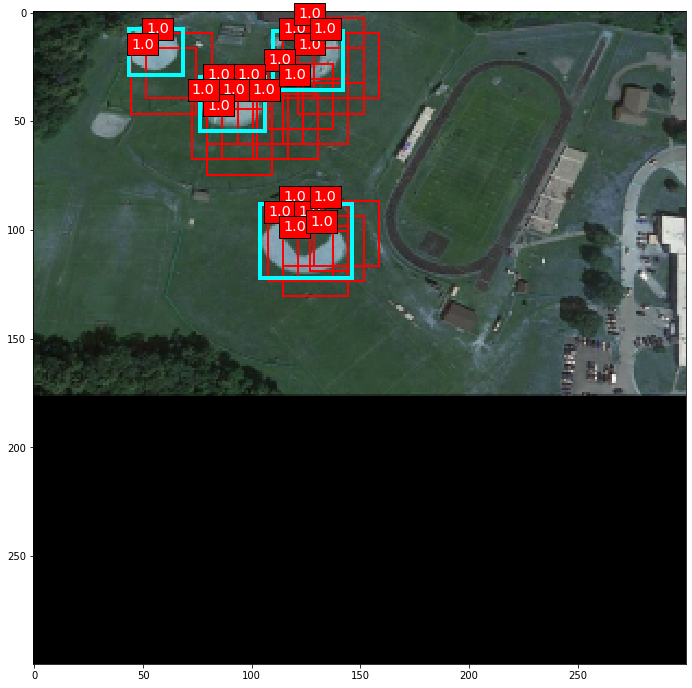

In [149]:
plot_one_sample( ssd_test_img[100], re_test_label[100], decode_test_pred[100],  org_image = False )

In [238]:
AP, meanAP = mAP(re_test_label, decode_test_pred)
print('mAP for test img : {}'.format(meanAP))

mAP for test img : 0.35311760063141284


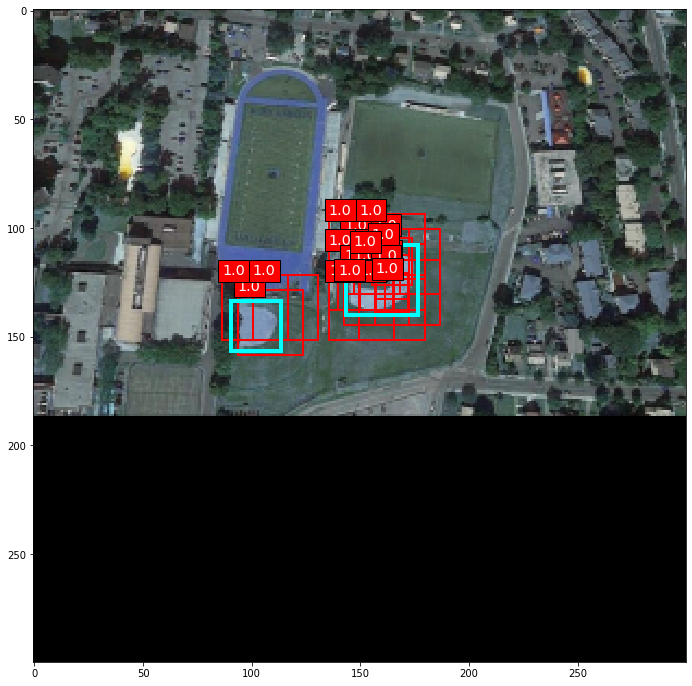

In [246]:
i = 103
plot_one_sample( ssd_test_img[i], re_test_label[i], decode_test_pred[i], org_image = False )

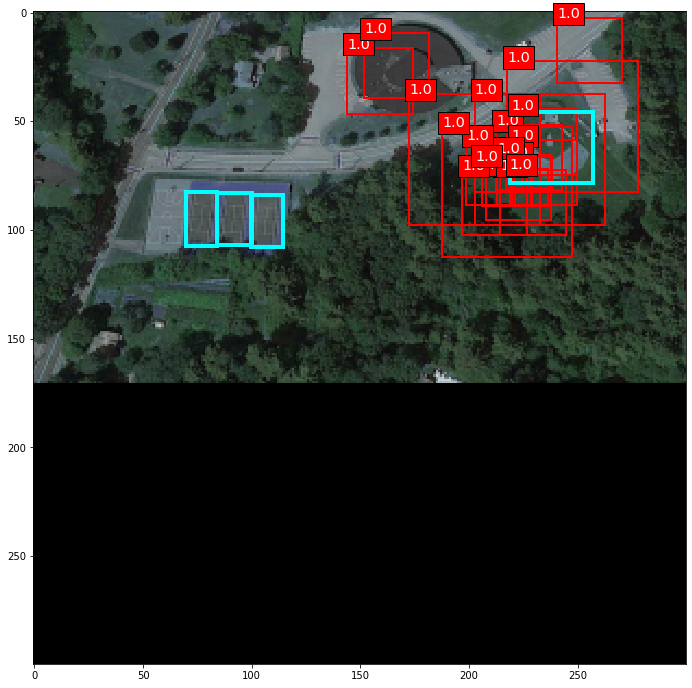

In [273]:
i = 98  
plot_one_sample(ssd_test_img[i],re_test_label[i],decode_test_pred[i],org_image = False)